## Load data

In [1]:
import pandas as pd
from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

name_data = urlopen('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
lines = [l.decode("utf-8") for l in name_data if ':' in l.decode("utf-8") and '|' not in l.decode("utf-8")]

features = [l.split(':')[0] for l in lines]
label_name = 'income'

cat_features = [l.split(':')[0] for l in lines if 'continuous' not in l]

train_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names=features + [label_name])
val_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      names=features + [label_name], skiprows=1)

val_df[label_name] = val_df [label_name].str[:-1]

encoder = LabelEncoder()
encoder.fit(train_df[label_name])
train_df[label_name] = encoder.transform(train_df[label_name])
val_df[label_name] = encoder.transform(val_df[label_name])

## Create Dataset

In [2]:
from deepchecks import Dataset

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                'race', 'sex', 'native-country']
train_ds = Dataset(train_df, label=label_name, cat_features=cat_features)
validation_ds = Dataset(val_df, label=label_name, cat_features=cat_features)

numeric_features = list(set(train_ds.features) - set(cat_features))


## Classification model

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

numeric_transformer = SimpleImputer()
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OrdinalEncoder())]
)

train_ds.features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

model = Pipeline(steps=[("preprocessing", preprocessor), ("model", RandomForestClassifier(max_depth=5, n_jobs=-1))])
model.fit(train_ds.features_columns, train_ds.label_col)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['capital-loss', 'age',
                                                   'fnlwgt', 'capital-gain',
                                                   'education-num',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                              

Segment Performance

Display performance score segmented by 2 top (or given) features in a heatmap.

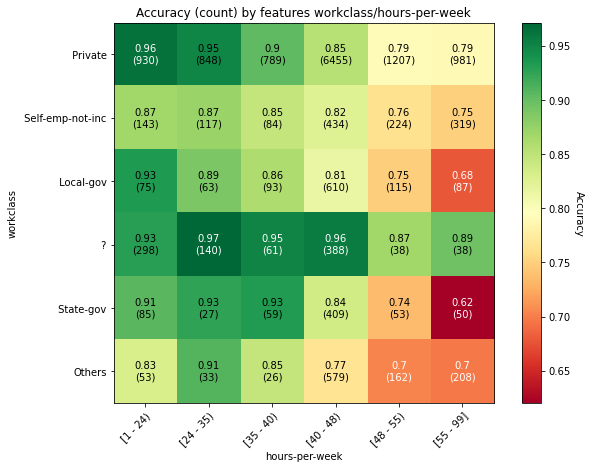

In [4]:
from deepchecks.checks.performance import SegmentPerformance

SegmentPerformance(feature_1='workclass', feature_2='hours-per-week').run(validation_ds, model)